In [1]:
import gc
import time
import numpy as np
import pandas as pd
import plotly.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
start_time = time.time()
train=pd.read_table('input/train.tsv', engine='c')
test = pd.read_table('input/test.tsv', engine='c')
print('[{}] Finished to load data'.format(time.time() - start_time))

[11.126576900482178] Finished to load data


## General Data information

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [7]:
print("Shipping=1:",len(train[train.shipping==1]))
print("Shipping=0:",len(train[train.shipping==0]))

Shipping=1: 663100
Shipping=0: 819435


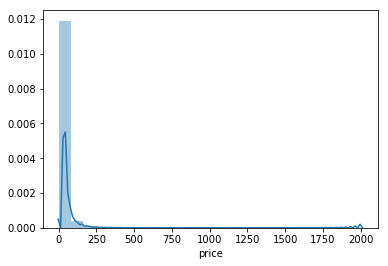

In [8]:
sns.distplot(train['price'],bins=25)

In [9]:
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [10]:
train['category_name'].value_counts()[-5:]

Handmade/Weddings/Frames               1
Handmade/Others/Educational            1
Handmade/Accessories/Mirror            1
Handmade/Bags and Purses/Diaper Bag    1
Handmade/Needlecraft/Clothing          1
Name: category_name, dtype: int64

In [11]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))

In [12]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [13]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


Number of Items by SubCategory

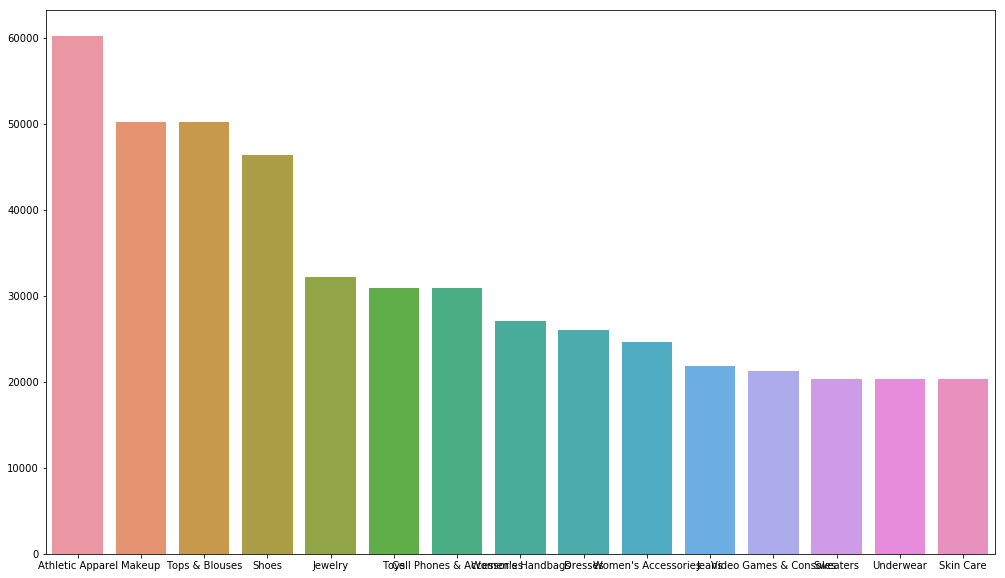

In [32]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_2'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

plt.figure(figsize=(17,10))
sns.barplot(x=x,y=y)
plt.show()

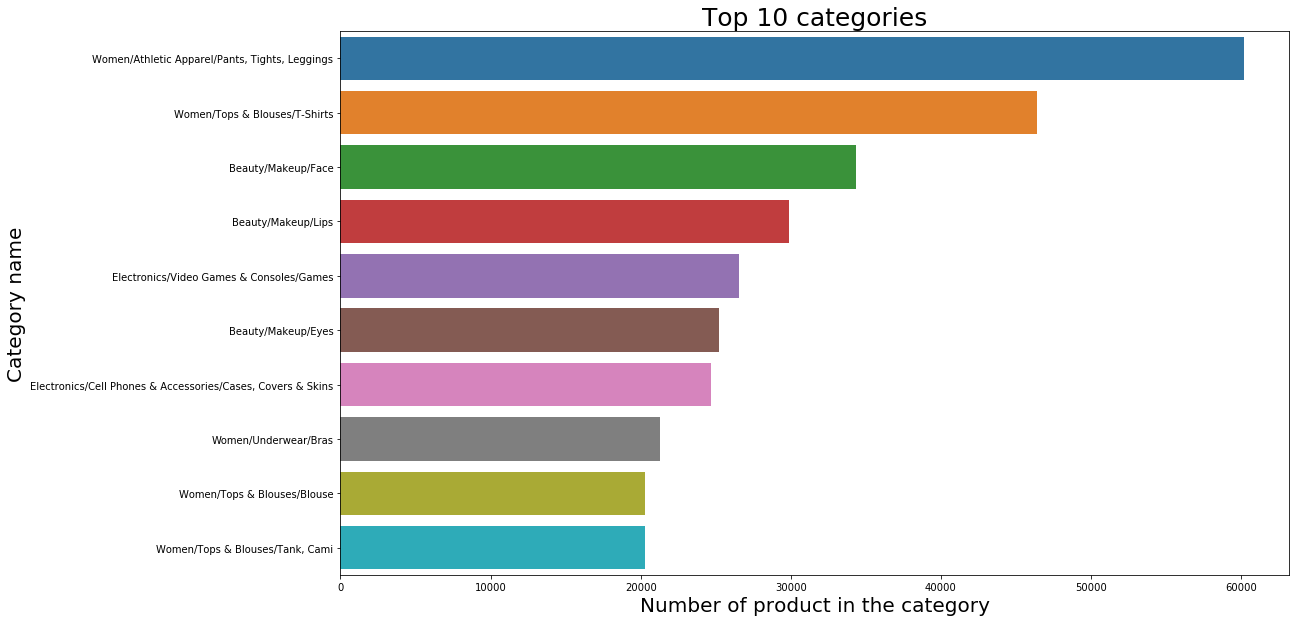

In [29]:
plt.figure(figsize=(17,10))
sns.countplot(y = train.category_name, \
              order = train.category_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 categories', fontsize = 25)
plt.ylabel('Category name', fontsize = 20)
plt.xlabel('Number of product in the category', fontsize = 20)
plt.show()

(0.0, 100.0, 0.0, 100.0)

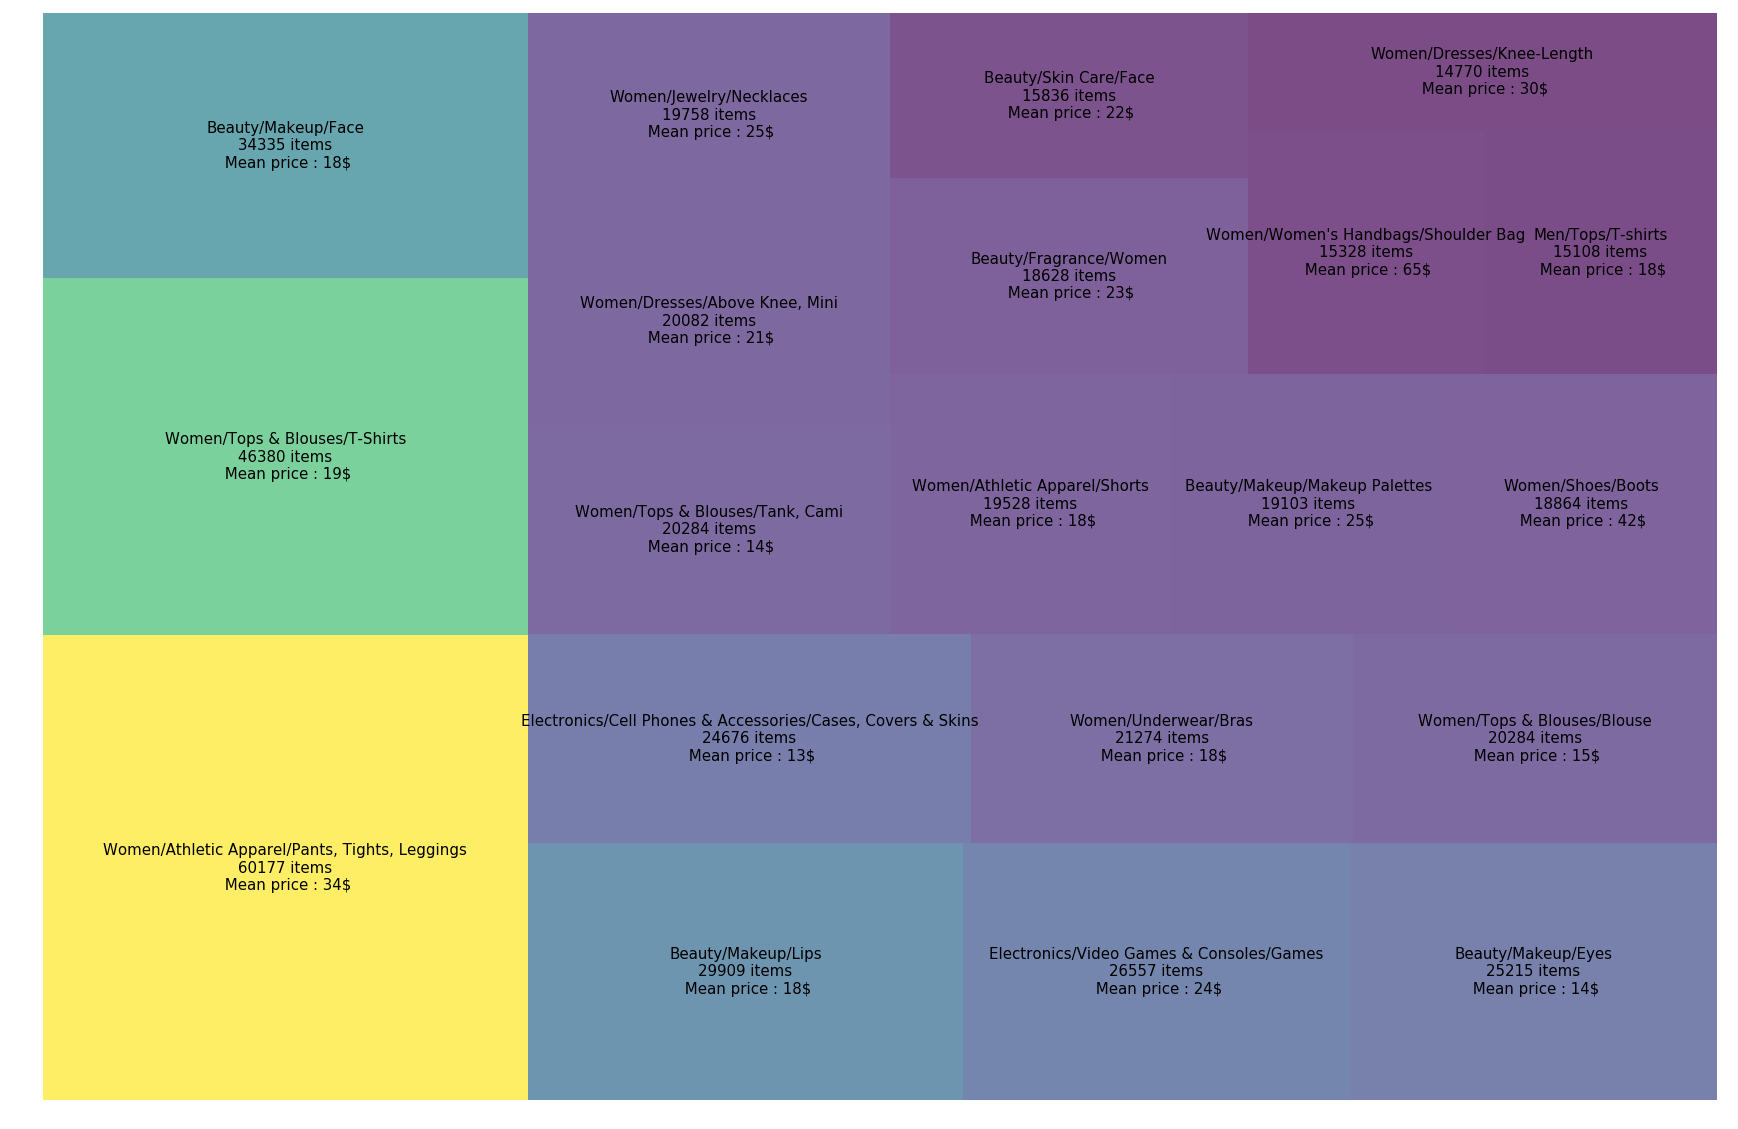

In [45]:
import squarify 
# Size of each category
cats = pd.DataFrame(train.category_name.value_counts())
cats.reset_index(level = 0, inplace=True)
cats = cats.sort_values(by='category_name', ascending = False).head(20)
cats.columns =('category_name', 'size')

# Price by category
group = train.groupby(train.category_name)
mean_price = group.price.mean()
mean_price = pd.DataFrame(mean_price)
mean_price.reset_index(level = 0, inplace=True)

# Merging
cats = pd.merge(cats, mean_price, how='left', on = 'category_name')

# Colors setting
cmap = matplotlib.cm.viridis
mini=min(cats['size'])
maxi=max(cats['size'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in cats['size']]

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(cats['category_name'], cats['size'], cats['price'])]

# Plotting
plt.figure(figsize=(30,20))
plt.rc('font', size=15)
squarify.plot(sizes = cats['size'], label = labels, alpha = .7, color=colors)
plt.axis('off')

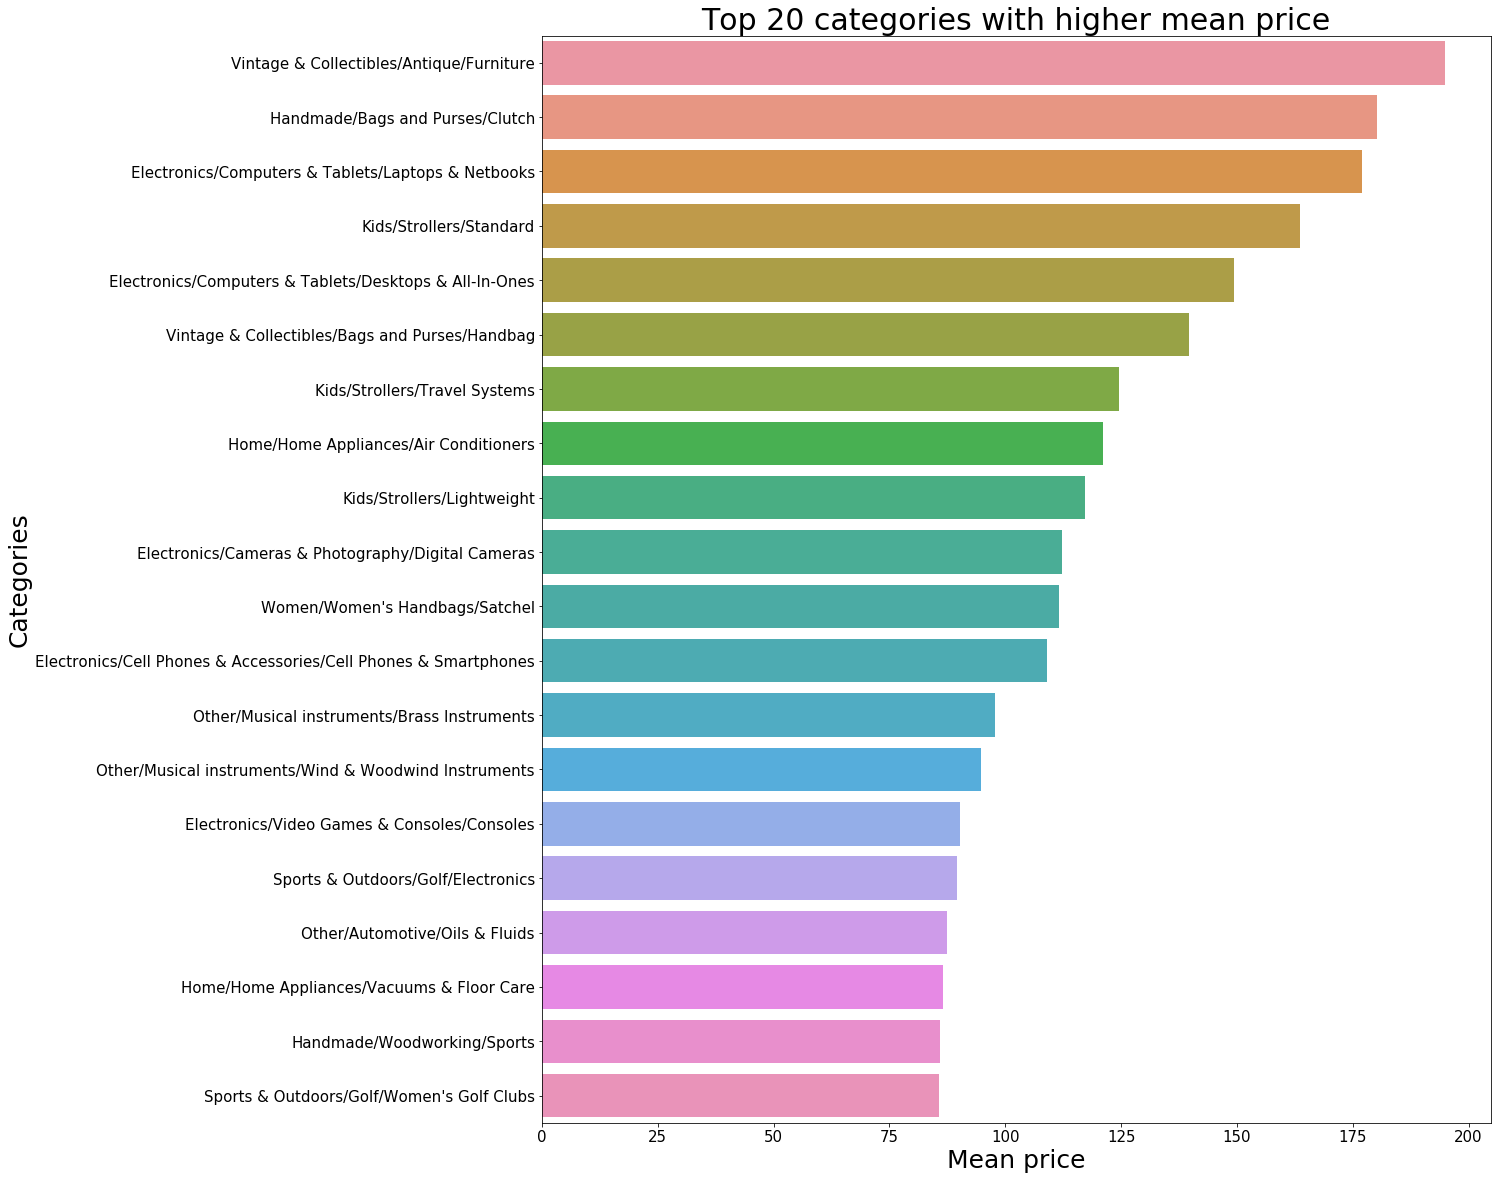

In [48]:
group = train.groupby(train.category_name)
mean_price = pd.DataFrame(group.price.mean())
mean_price = mean_price.sort_values(by='price', ascending = False).head(20)
mean_price.reset_index(level = 0, inplace=True)

plt.figure(figsize=(17,20))
sns.barplot(x = 'price', y = 'category_name', data = mean_price, orient = 'h')
plt.title('Top 20 categories with higher mean price', fontsize = 30)
plt.ylabel('Categories', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)
plt.show()

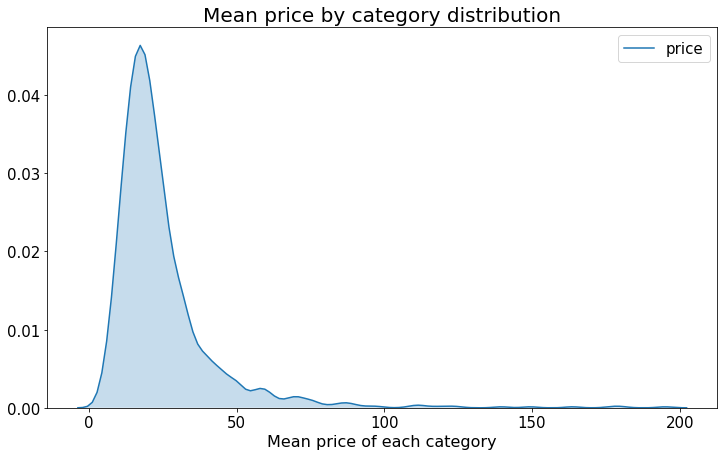

In [49]:
mean_price_2 = pd.DataFrame(group.price.mean())
mean_price_2.reset_index(level = 0, inplace=True)

plt.figure(figsize =(12,7))
sns.kdeplot(mean_price_2.price, shade = True)
plt.title('Mean price by category distribution', fontsize = 20)
plt.xlabel('Mean price of each category', fontsize = 16)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



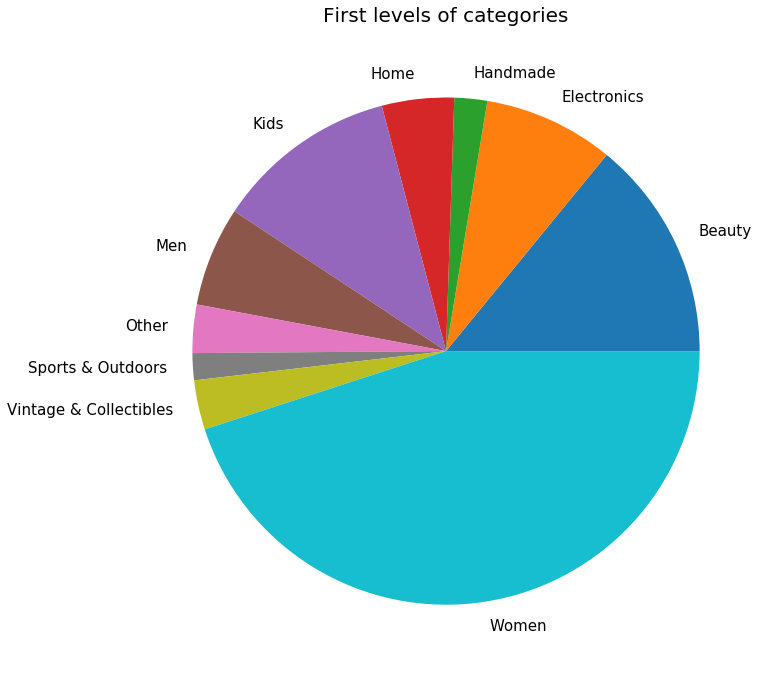

In [50]:
train['cat1'] = train.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
train['cat2'] = train.category_name.str.extract('([^/]+/[^/]+)/[^/]+')

plt.figure(figsize = (10,12))
train.name.groupby(train.cat1).count().plot(kind = 'pie')
plt.title ('First levels of categories', fontsize = 20)
plt.axis('equal')
plt.ylabel('')
plt.show()

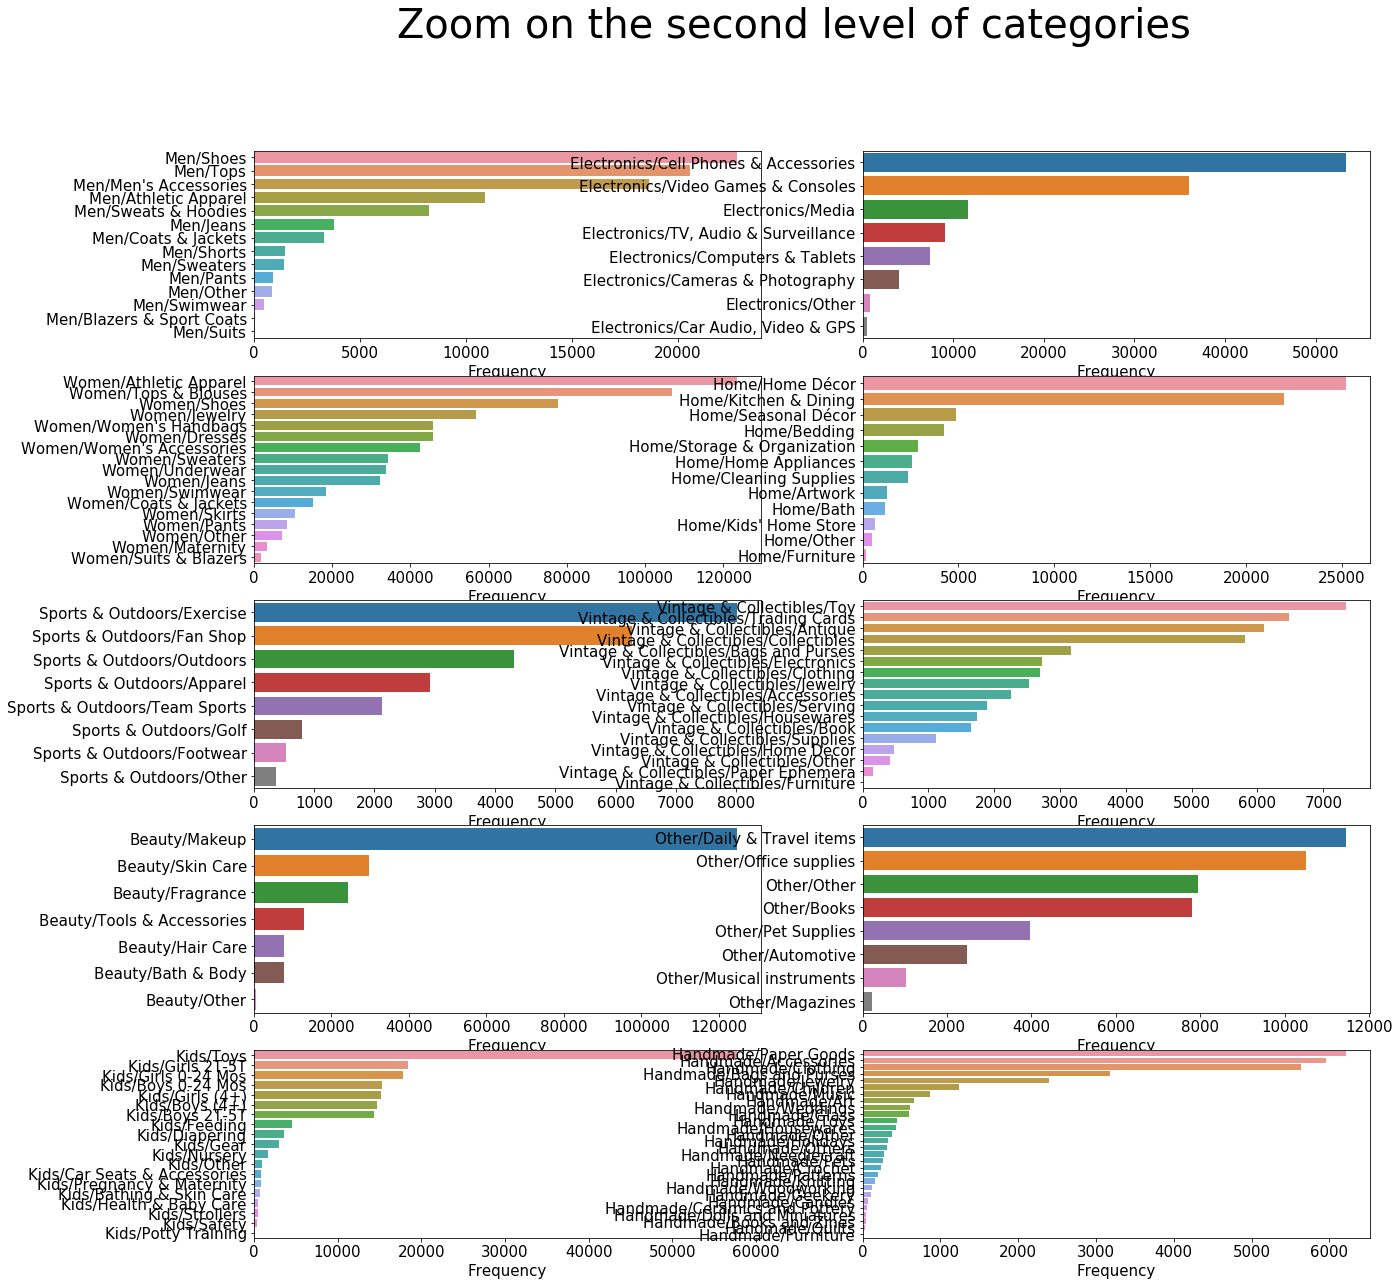

In [51]:
# We stock each variable's repartition into a dictionary
alldf = {}
for col in train.cat1[train.cat1.isnull() == False].unique() :

    temp = train.cat2[train['cat1'] == col]
    temp = pd.DataFrame(temp.value_counts().reset_index())
    
    alldf[col] = temp

# Now we can plot it    
i = 0
fig, axs = plt.subplots(5,2, figsize=(20,20))   
plt.suptitle('Zoom on the second level of categories', fontsize = 40) 

for cat in alldf:
    temp = alldf[cat]
    sns.barplot('cat2', 'index', data = temp, ax = axs.flatten()[i])
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].set_xlabel('Frequency')
    i+=1    

**Prices of the first level of categories**

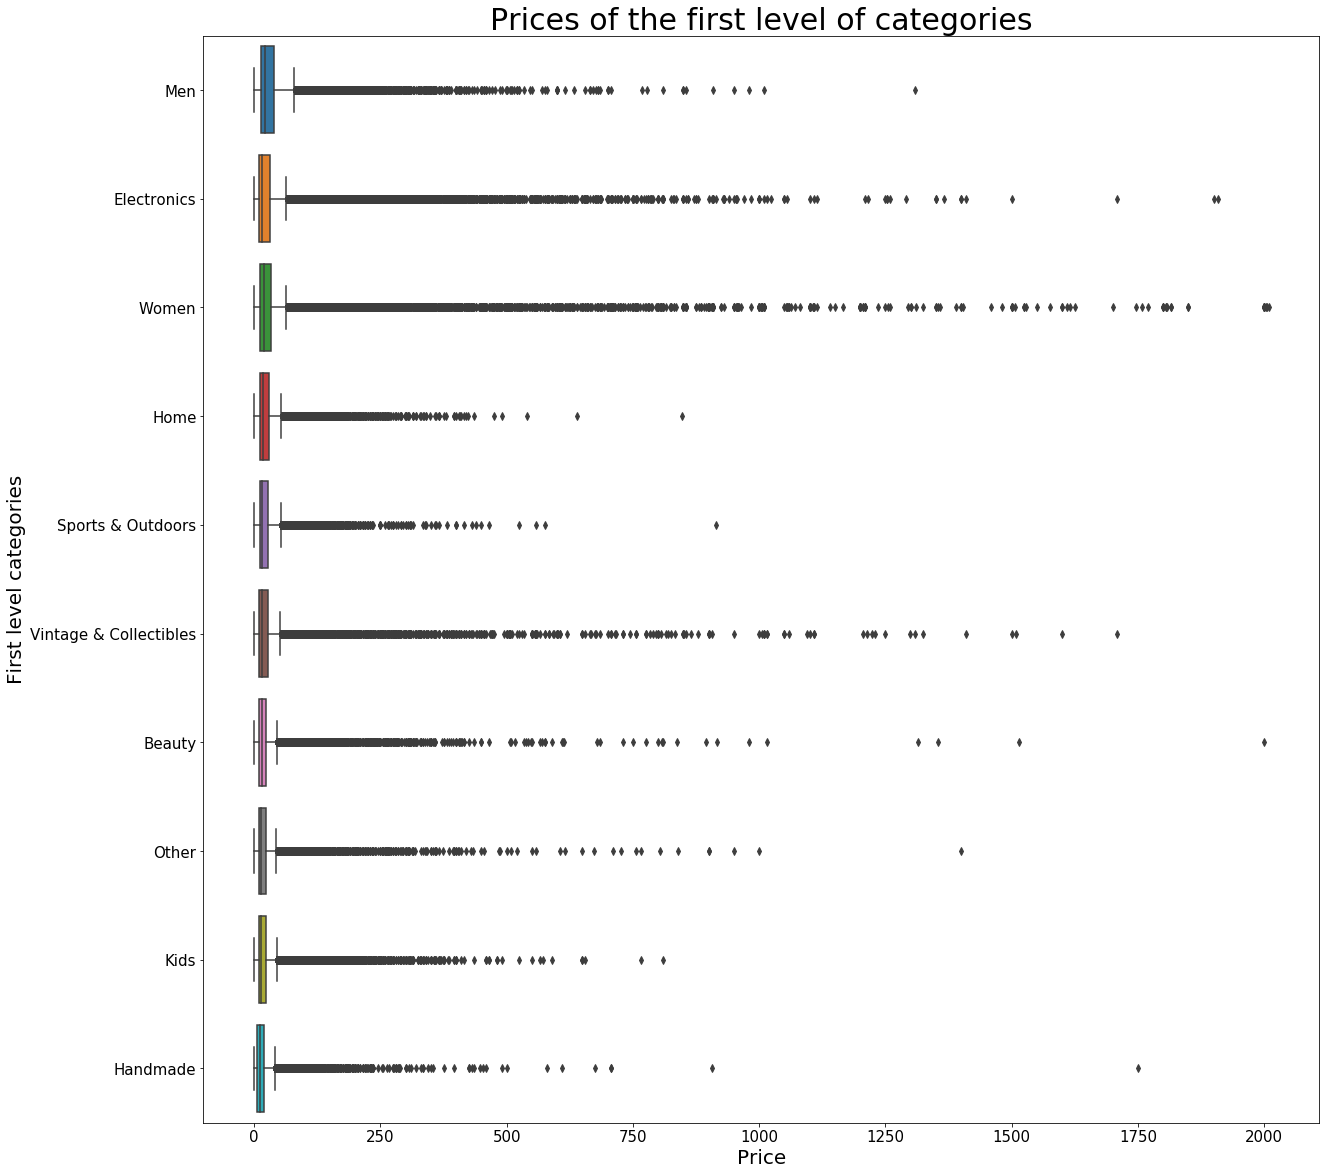

In [53]:
plt.figure(figsize=(20,20))
sns.boxplot( x = 'price' , y = 'cat1', data = train, orient = 'h')
plt.title('Prices of the first level of categories', fontsize = 30)
plt.ylabel ('First level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)
plt.show()

Level 2

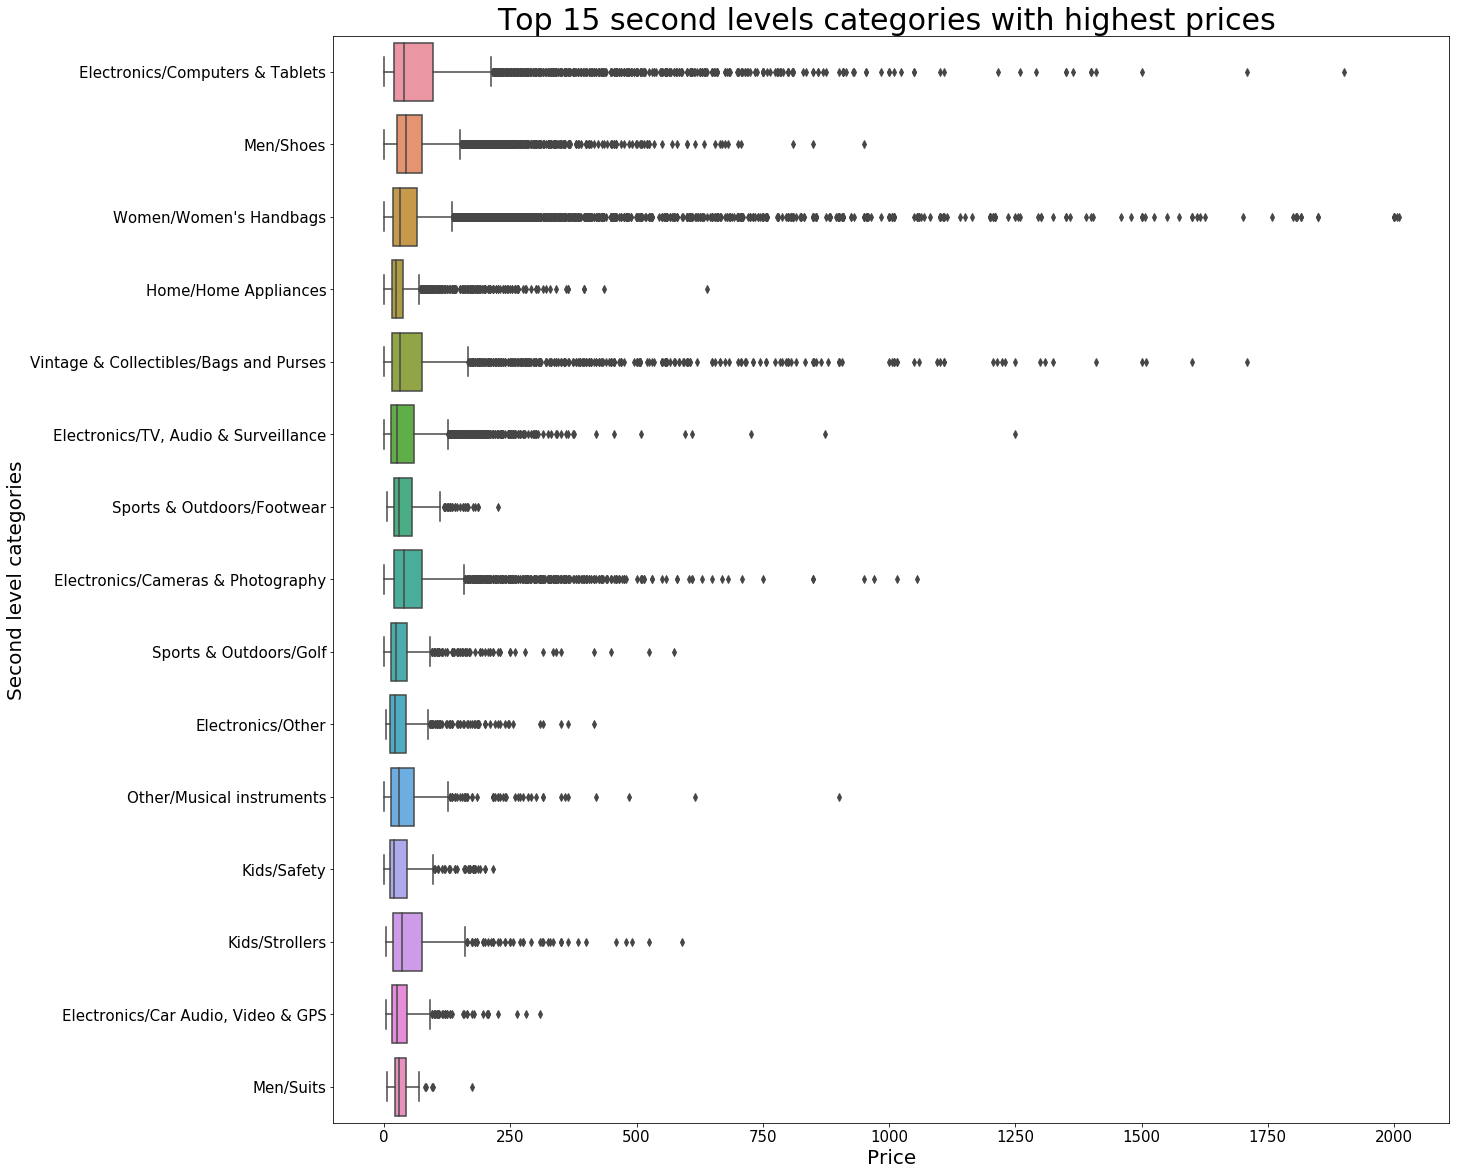

In [55]:
#Firstly, we create a ranking of our level 2 categories, by price
level2 =  train.groupby('cat2')
rank_level2 = pd.DataFrame(level2.mean()).sort_values(by='price')

#Then, we stock the top 15 most expensive into a list
top_cat2 = rank_level2.tail(15).reset_index()
top_cat2_list = top_cat2.cat2.unique().tolist()
#We don't only want mean price by category, but all basics statistics, so we need the full series
top_cat2_full = train.loc[train['cat2'].isin(top_cat2_list)]

#We can now plot it !
plt.figure(figsize=(20,20))
sns.boxplot(y ='cat2',x= 'price', data = top_cat2_full, orient = 'h')
plt.title('Top 15 second levels categories with highest prices ', fontsize = 30)
plt.ylabel ('Second level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)
plt.show()

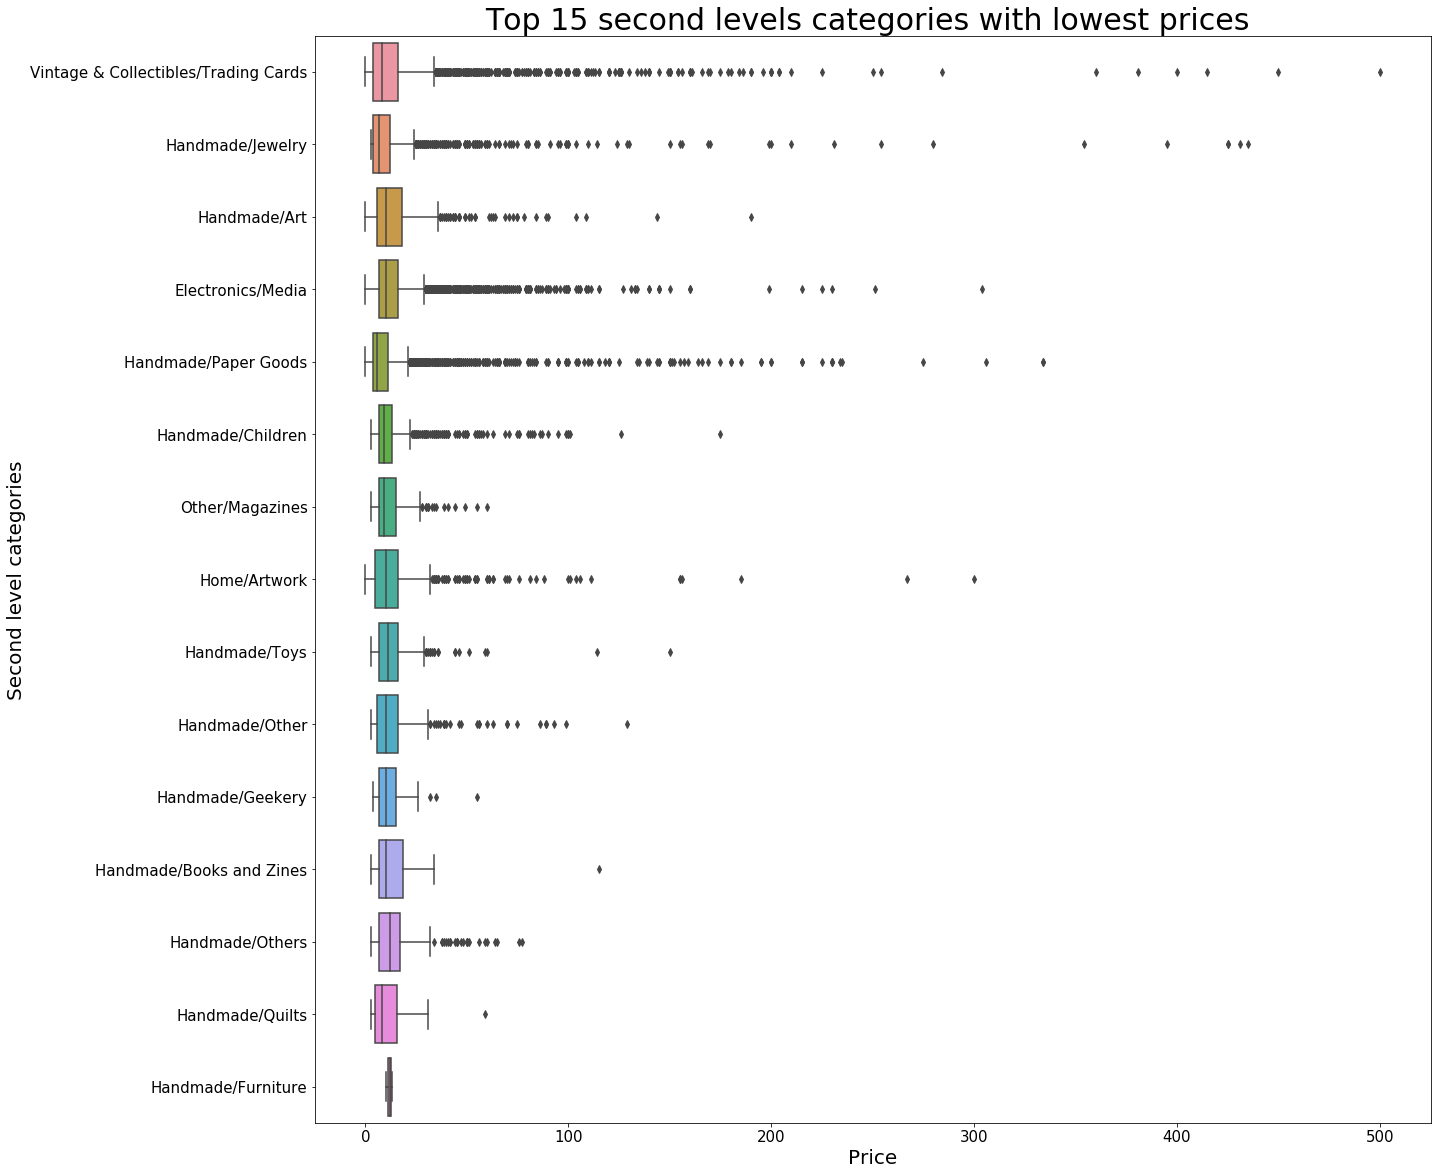

In [56]:
botom_cat2 = rank_level2.head(15).reset_index()
botom_cat2_list = botom_cat2.cat2.unique().tolist()
botom_cat2_full = train.loc[train['cat2'].isin(botom_cat2_list)]

plt.figure(figsize=(20,20))
sns.boxplot(y ='cat2',x= 'price', data = botom_cat2_full, orient = 'h')
plt.title('Top 15 second levels categories with lowest prices ', fontsize = 30)
plt.ylabel ('Second level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)
plt.show()

Brand Name

In [19]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [21]:
# add a column of word counts to both the training and test set

def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [22]:
train.groupby('desc_len')['price'].mean().reset_index()

,desc_len,price
0,0,26.737516


In [38]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

# Data Storage
train.to_csv("EDA_processed_train.csv",encoding='utf-8')
test.to_csv("EDA_processed_test.csv",encoding='utf-8')

Top 10 brands by number of products :

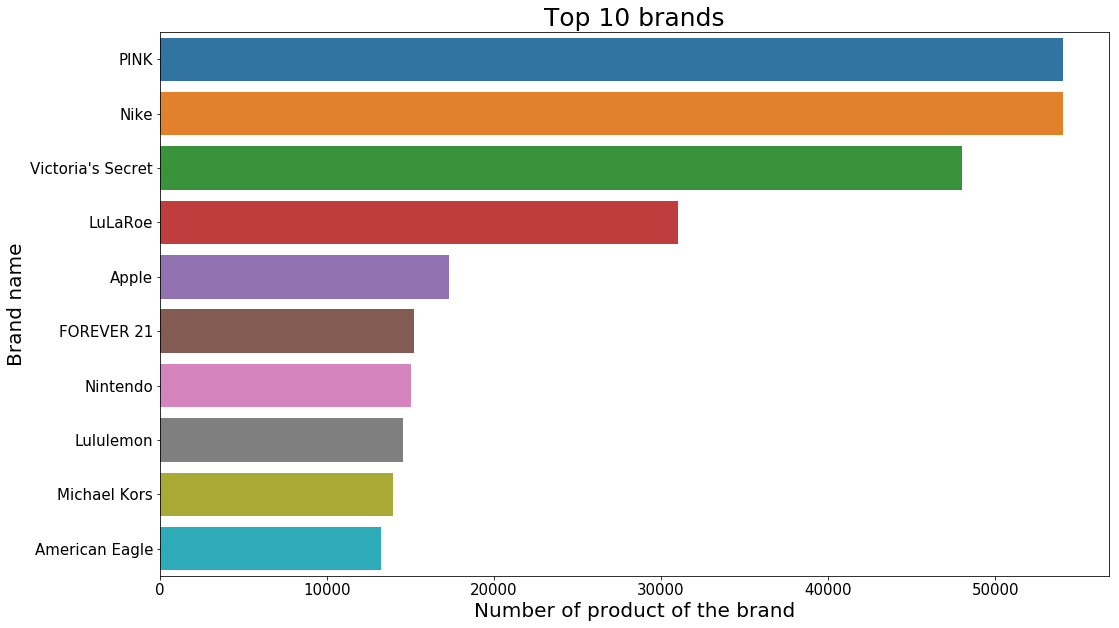

In [57]:
plt.figure(figsize=(17,10))
sns.countplot(y = train.brand_name, \
              order = train.brand_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 brands', fontsize = 25)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Number of product of the brand', fontsize = 20)

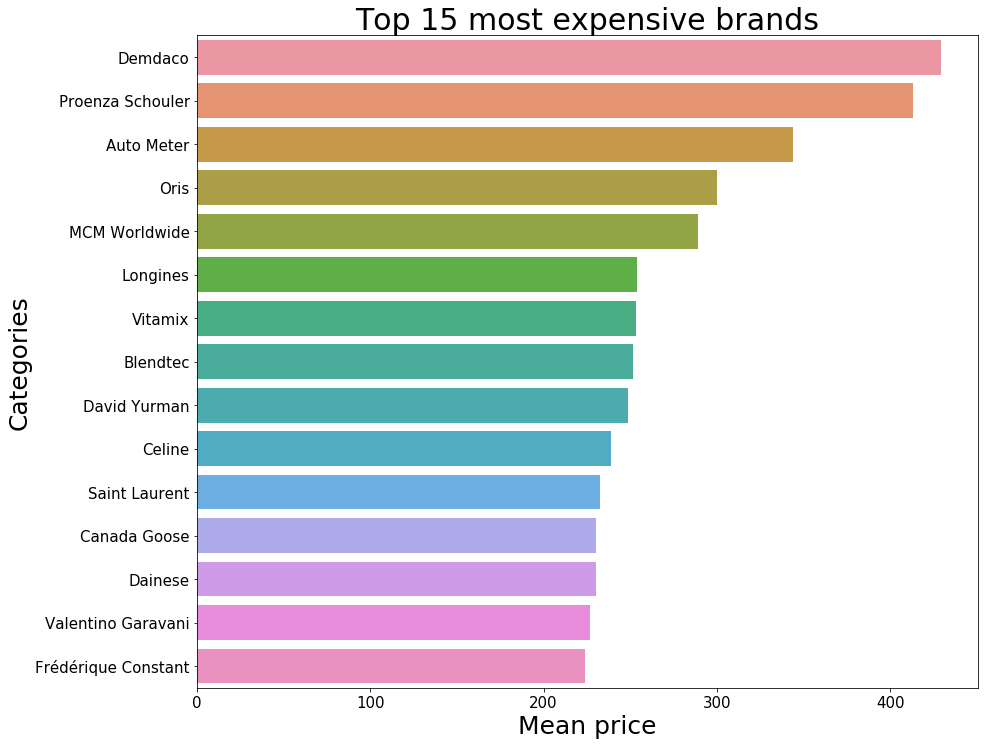

In [59]:
group = train.groupby (train.brand_name)
ranking = pd.DataFrame(group.price.mean())
ranking.reset_index(level = 0, inplace=True)
ranking = ranking.sort_values(by='price', ascending = False).head(15)

plt.figure(figsize=(14,12))
sns.barplot(x = 'price', y = 'brand_name', data = ranking, orient = 'h')
plt.title('Top 15 most expensive brands', fontsize = 30)
plt.ylabel('Categories', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)
plt.show()

More details

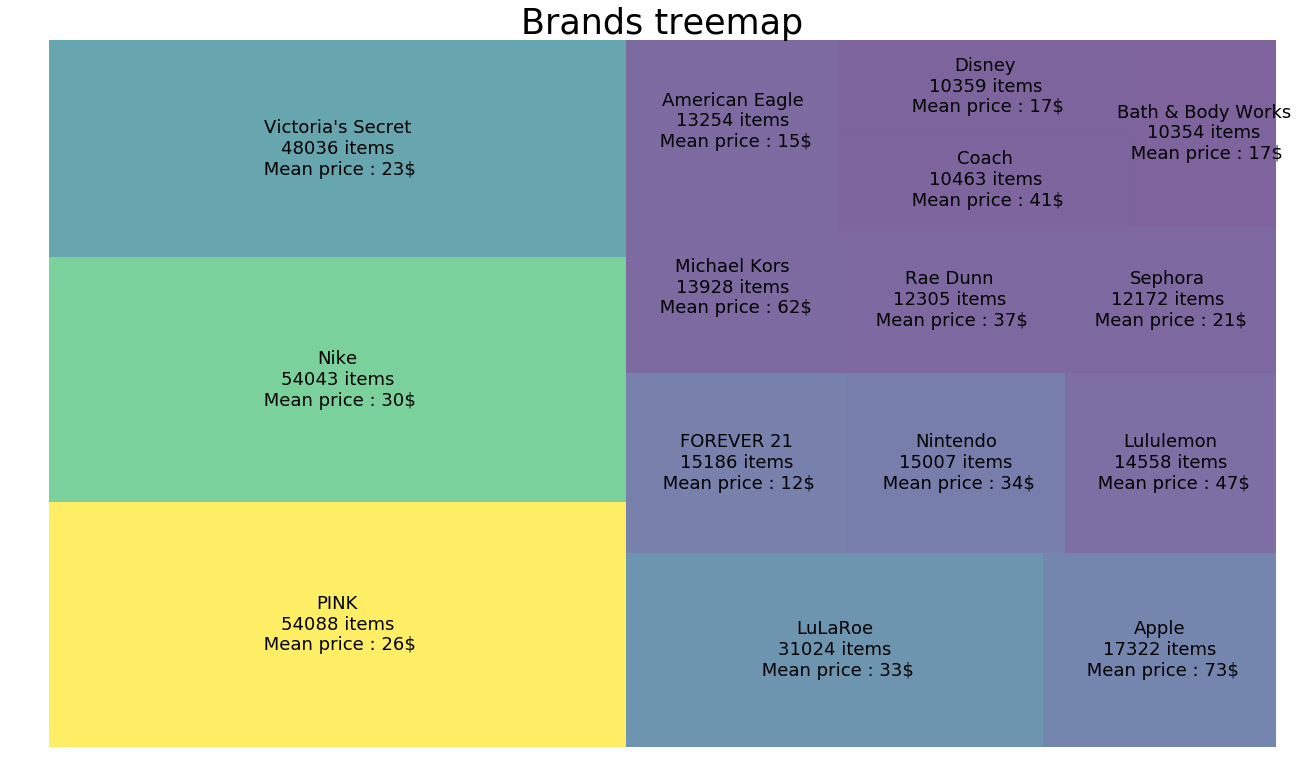

In [61]:
# Brands sorted by number of item
brands = pd.DataFrame(train.brand_name.value_counts())
brands.reset_index(level = 0, inplace=True)
brands = brands.sort_values(by='brand_name', ascending = False).head(15)
brands.columns = ('brand_name', 'number_of_item')

# Brands by price
group = train.groupby (train.brand_name)
brands_prices = pd.DataFrame(group.price.mean())
brands_prices.reset_index(level = 0, inplace=True)

# Merging
brands = pd.merge(brands, brands_prices, how = 'left', on = 'brand_name')

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(brands['brand_name'], brands['number_of_item'], brands['price'])]

# Plotting
plt.figure(figsize=(22,13))
plt.rc('font', size=18)
squarify.plot(sizes = brands['number_of_item'], label = labels, alpha = .7, color=colors)
plt.title('Brands treemap', fontsize = 35)
plt.axis('off')
plt.show()

## Categories

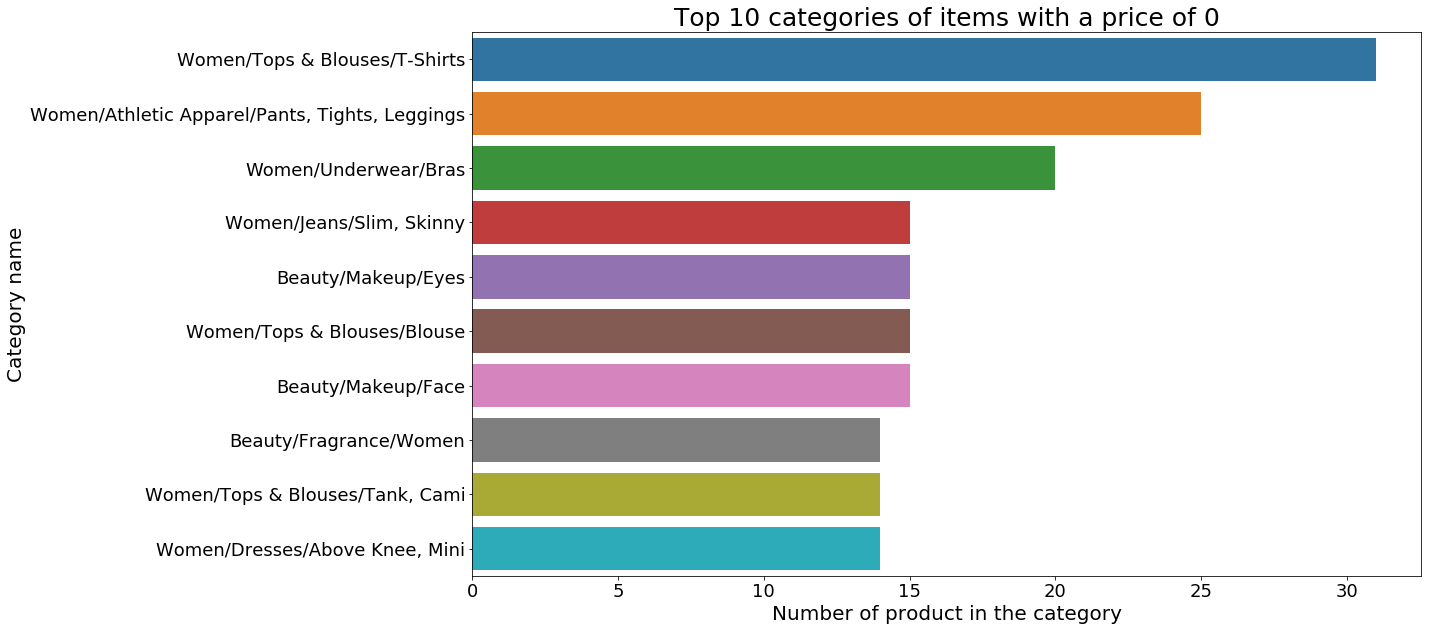

In [63]:
price_of_zero = train.loc[train.price == 0]

plt.figure(figsize=(17,10))
sns.countplot(y = price_of_zero.category_name, \
              order = price_of_zero.category_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 categories of items with a price of 0', fontsize = 25)
plt.ylabel('Category name',  fontsize = 20)
plt.xlabel('Number of product in the category',  fontsize = 20)
plt.show()

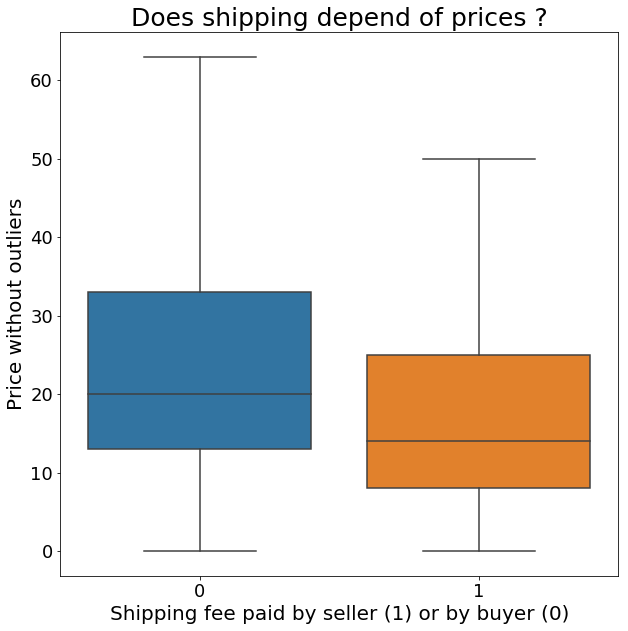

In [64]:
plt.figure(figsize=(10,10))
sns.boxplot(x=train.shipping, y = train.price, showfliers=False, orient = 'v')
plt.title('Does shipping depend of prices ?', fontsize = 25)
plt.xlabel('Shipping fee paid by seller (1) or by buyer (0)', fontsize = 20)
plt.ylabel('Price without outliers', fontsize = 20)
plt.show()

We use the option "showfliers=False" to flat the graph (because of those few very high prices). As expected, seller are paying shipping fees more often when a item is more expensive.

In [65]:
train['no_descrip'] = 0
train.loc[train.item_description=='No description yet', 'no_descrip'] = 1
i = str(round(train['no_descrip'].value_counts(normalize=True).iloc[1] * 100,2)) + '%'

print(i, 'of the items have no a description.')

5.56% of the items have no a description.
